# CEO-REQUEST CHALLENGE

> Should Olist remove underperforming sellers from its marketplace?

## Problem statement

To analyse the impact of removing the worse sellers from Olist's marketplace, we can start with a what-if analysis: What would have happened if Olist had never accepted these sellers in the first place? For that:

Step ① Compute, for each `seller_id`, and cumulated since the beginning:
- The `revenues` it brings
- The `costs` associated with all its bad reviews
- The resulting `profits` (revenues - costs)
- The number of `orders` (it will impact overall IT costs)


Step ② We can then sort sellers by increasing profits for Olist, and for each number of sellers to remove, compute the financial impact it would have made had they never been accepted on the platform. We may find an optimal number of sellers to remove that maximizes Olist's profit margin

In [1]:
# Write down a detailed strategy (step by step) to create the DataFrame you need for step 1
# Think about how to re-use or update the logic you have already coded in your `olist` package

<details>
    <summary>Hints</summary>


Starting from your current `seller().get_training_data()` DataFrame:
- Can you easily transform it to compute Olist's positive `revenue_per_seller`? 
- Can you easily transform it to compute Olist's `cost_of_bad_reviews`?

❓Instead of starting again from scratch, investigate your source code in `seller.py` - how was the mean `review_score` per seller computed? Can you imagine a way to amend your code  to compute `cost_of_reviews` in the same process? 
</details>


## PROFIT MAXIMIZATION

### Import

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import statsmodels.formula.api as smf

In [3]:
sns.set(context='talk', style='whitegrid', palette='Set1')

In [4]:
from olist.seller import Seller
sellers = Seller().get_training_data()

In [5]:
from olist.order import Order
orders = Order().get_training_data()

In [6]:
from olist.data import Olist
data = Olist().get_data()

### Profit

In [7]:
def compute_month(sellers):
    return np.maximum(
        np.ceil((sellers["date_last_sale"] - sellers["date_first_sale"]) /
                np.timedelta64(1, 'M')), 1)

def compute_revenue_per_seller(sellers):
    return sellers["sales"] * .1 + 80 * sellers["month"]

def compute_cost_of_bad_reviews(sellers):
    return sellers["count_one_stars"] * 100 \
        + sellers["count_two_stars"] * 50 \
        + sellers["count_three_stars"] * 40

def compute_IT_costs(sellers):
    X = sellers[["n_orders"]].copy()
    return 500_000 / np.sum(np.sqrt(X["n_orders"])) * np.sqrt(X["n_orders"])

def compute_profite(sellers):
    sellers["month"] = compute_month(sellers)
    sellers["revenue_per_seller"] = compute_revenue_per_seller(sellers)
    sellers["cost_of_bad_reviews"] = compute_cost_of_bad_reviews(sellers)
    sellers["it_costs"] = compute_IT_costs(sellers)
    sellers["profit"] = sellers["revenue_per_seller"] - sellers[
        "cost_of_bad_reviews"] - sellers["it_costs"]
    return sellers


### PROFIT PER SELLERS

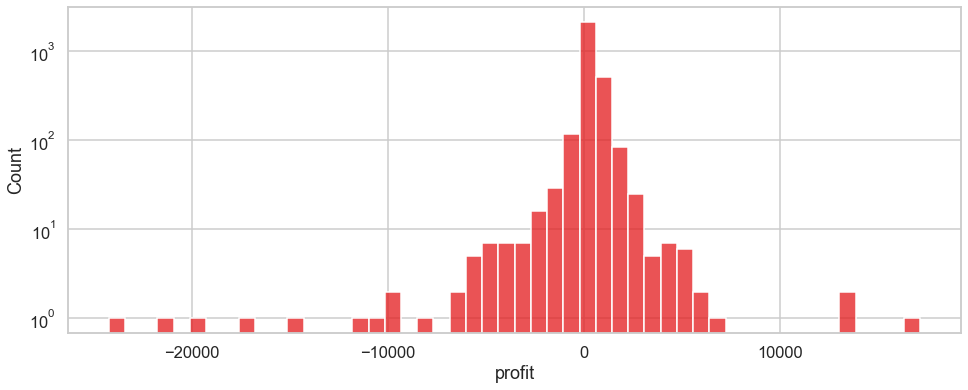

In [8]:
sellers = compute_profite(sellers)
fig, ax = plt.subplots(1,1,figsize=(16,6))
sns.histplot(sellers["profit"],bins=50,log_scale=(False,True),ax=ax);

### REMOVING BAD SELLERS

In [9]:
def compute_new_profit(sellers,nb_sellers_to_remove):
    X = sellers.sort_values(by="profit", ascending=True).iloc[nb_sellers_to_remove:,:].copy()
    X['new_it_costs'] = compute_IT_costs(X)
    X["new_profit"] = X["revenue_per_seller"] - X["cost_of_bad_reviews"] - X["new_it_costs"]
    return X


In [10]:
new_profit = []
new_it_cost = []
new_cost_of_bad_reviews = []
new_revenue_per_seller = []

nb_sellers_to_remove = 2000
for i in range(nb_sellers_to_remove):
    X = compute_new_profit(sellers,i)
    new_profit.append(X['profit'].sum())
    new_it_cost.append(X['it_costs'].sum())
    new_cost_of_bad_reviews.append(X['cost_of_bad_reviews'].sum())
    new_revenue_per_seller.append(X['revenue_per_seller'].sum())
    

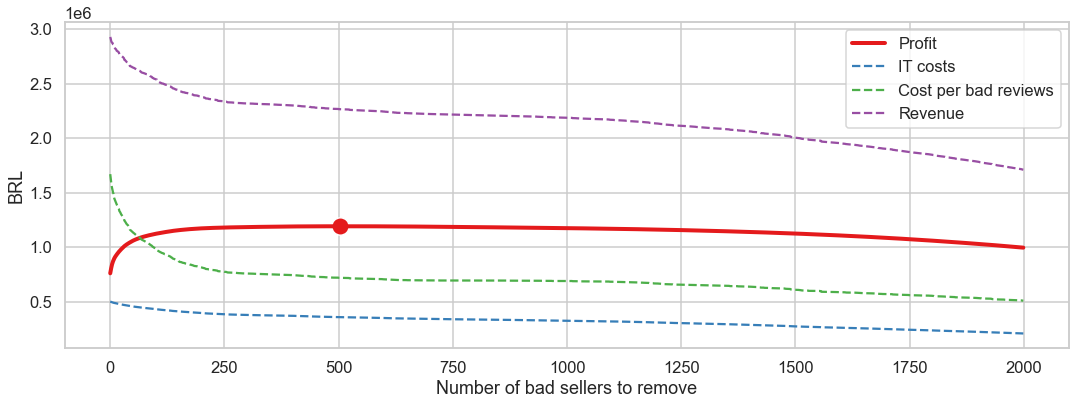

In [11]:
fig,ax = plt.subplots(1,1,figsize=(18,6))
sns.lineplot(x=range(nb_sellers_to_remove), y=new_profit,ax=ax,label="Profit",linewidth=4);
sns.lineplot(x=range(nb_sellers_to_remove), y=new_it_cost,ax=ax,label="IT costs",linestyle="--");
sns.lineplot(x=range(nb_sellers_to_remove), y=new_cost_of_bad_reviews,ax=ax,label="Cost per bad reviews",linestyle="--");
sns.lineplot(x=range(nb_sellers_to_remove), y=new_revenue_per_seller,ax=ax,label="Revenue",linestyle="--");

sns.scatterplot(x=[np.argmax(new_profit)], y=[np.max(new_profit)],ax=ax,s=300);
#ax.axvline([np.argmax(new_profit)],color="black",linestyle="--")
ax.set_xlabel("Number of bad sellers to remove");
ax.set_ylabel("BRL");


In [12]:
print(f"Number of bad sellers to remove: {np.argmax(new_profit)}")
print(f"new profit: {int(np.round(np.max(new_profit)))} BRL")
print(f"Gain:  {np.round(np.max(new_profit) - new_profit[0])} BRL")
print(f"Gain:  {np.round(np.max(new_profit) - new_profit[0]) / new_profit[0]} BRL")

Number of bad sellers to remove: 502
new profit: 1191172 BRL
Gain:  431727.0 BRL
Gain:  0.5684768122262889 BRL


- Number of sellers to remove: **502**

- New Profit: **1 191 172** BRL

- Gain: **431 727** BRL (56%)

## PROBLEM

**This is a "Post-Mortem" analysis**

**We need to find a way to detect the bad sellers early**

## BAD SELLERS versus GOOD SELLERS

In [13]:
sellers["seller_type"] = "Good"
sellers.sort_values(by="profit", ascending=True,inplace=True)
sellers.loc[sellers.index[0:np.argmax(new_profit)],"seller_type"] = "Bad"

### DATA

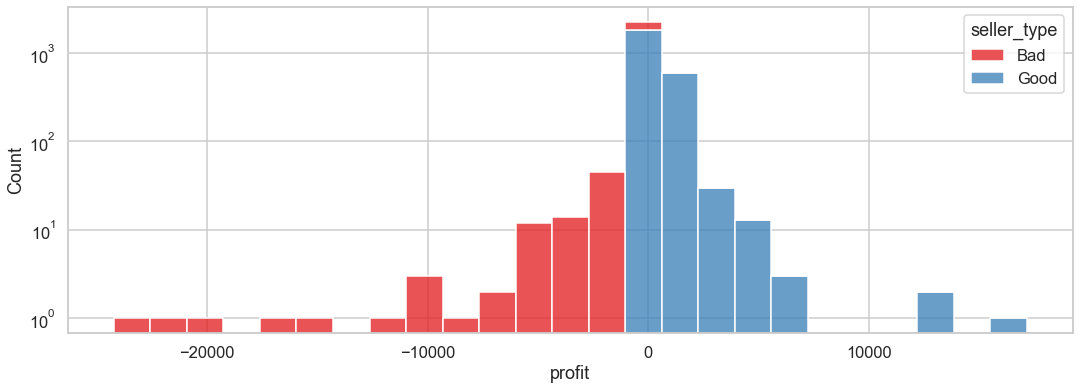

In [24]:
fig,ax = plt.subplots(1,1,figsize=(18,6))
sns.histplot(x='profit',data=sellers,bins=25,hue="seller_type",log_scale=(False,True),ax=ax,multiple="stack",);


In [17]:
#fig,ax = plt.subplots(1,1,figsize=(18,4))
#sns.histplot(x='revenue_per_seller',data=sellers,bins=25,hue="seller_type",log_scale=(False,True),ax=ax[0],multiple="stack",);
#sns.histplot(x='profit',data=sellers,bins=25,hue="seller_type",log_scale=(False,True),ax=ax,multiple="stack",);


- Bad sellers: negative profit
- Good sellers: positive profit

In [18]:
#fig,ax = plt.subplots(1,2,figsize=(18,4))
#sns.histplot(x='cost_of_bad_reviews',data=sellers,bins=25,hue="seller_type",log_scale=(False,True),ax=ax[0],multiple="stack",);
#sns.histplot(x='it_costs',data=sellers,bins=25,hue="seller_type",ax=ax[1],multiple="stack",);


In [19]:
# Data preparation
df_orders = data["orders"]
df_orders_item = data["order_items"]
df_reviews = data["order_reviews"]

df_orders_item = df_orders_item.groupby(by=["order_id","seller_id"]).agg({"price": sum}).reset_index()
df = df_orders.merge(df_orders_item,on="order_id").merge(df_reviews,on="order_id")

df = df[["seller_id","order_id","order_purchase_timestamp","price","review_score"]]
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])

In [20]:
s = 25
r = 6
good_seller_ids =sellers.loc[sellers.seller_type == "Good","seller_id"]#.sample(s, random_state=r)
bad_seller_ids =sellers.loc[sellers.seller_type == "Bad","seller_id"] #.sample(s, random_state=r)

#good_seller_ids = []
#bad_seller_ids = []

seller_ids = good_seller_ids.append(bad_seller_ids)
seller_data = {}

for seller_id in seller_ids:
    # select one seller
    df_one_seller = df.loc[df.seller_id==seller_id,:].copy()
    df_one_seller.sort_values(by="order_purchase_timestamp",inplace=True)

    # Compute cost 1,2 an 3 stars
    df_one_seller["cost_one_stars"] = df_one_seller["review_score"].apply(lambda x: 100 if x==1 else 0)
    df_one_seller["cost_two_stars"] = df_one_seller["review_score"].apply(lambda x: 50 if x==2 else 0)
    df_one_seller["cost_three_stars"] = df_one_seller["review_score"].apply(lambda x: 40 if x==3 else 0)

    # Aggregate per week
    df_one_seller = df_one_seller.groupby(pd.Grouper(key='order_purchase_timestamp', freq='W-MON')).agg(
    {"price": sum, "cost_one_stars": sum, "cost_two_stars": sum, "cost_three_stars": sum, "order_id": 'count'})

    # Add subscription
    df_one_seller["cum_subscription"] = np.maximum(np.ceil((df_one_seller.index - df_one_seller.index[0] )/ np.timedelta64(1, 'M')),1)*80

    # Compute IT costs
    df_one_seller["n_orders"]=df_one_seller["order_id"].cumsum()
    seller_total_it_costs = sellers[sellers.seller_id == seller_id].it_costs
    df_one_seller["cum_it_costs"] = df_one_seller["n_orders"].apply(lambda x : seller_total_it_costs / np.sqrt(df_one_seller["n_orders"][-1]) * np.sqrt(x))


    # Compute cumulative revenue
    df_one_seller["cum_revenue"] = df_one_seller["price"].cumsum() * .1

    # Compute cumulative cost per bad reviews
    df_one_seller["cum_cost_one_stars"] = df_one_seller["cost_one_stars"].cumsum()
    df_one_seller["cum_cost_two_stars"] = df_one_seller["cost_two_stars"].cumsum()
    df_one_seller["cum_cost_three_stars"] = df_one_seller["cost_three_stars"].cumsum()
    df_one_seller["cum_cost_bad_reviews"] = df_one_seller["cum_cost_one_stars"] + df_one_seller["cum_cost_two_stars"] + df_one_seller["cum_cost_three_stars"]

    # Compute cumulative profit
    df_one_seller["cum_profit"] = df_one_seller["cum_revenue"] + df_one_seller["cum_subscription"] - df_one_seller["cum_cost_bad_reviews"] - df_one_seller["cum_it_costs"]


    # reset index
    df_one_seller.reset_index(inplace=True)
    
    # Select cumulative metrics
    seller_data[seller_id]= df_one_seller[["cum_profit","cum_revenue","cum_subscription","cum_cost_bad_reviews","cum_it_costs"]]


In [21]:
week_threshold = 20
profit_threshold = 0
balance =[]

for i in seller_ids:
    if seller_data[i].loc[min(week_threshold,seller_data[i].shape[0]-1),"cum_profit"] < profit_threshold:
        balance.append(seller_data[i]["cum_profit"].iloc[-1]-seller_data[i].loc[min(week_threshold,seller_data[i].shape[0]-1),"cum_profit"])

print(f"Gain: {np.abs(np.sum(balance))}")

Gain: 191759.99537151586


### CUMULATIVE PROFIT BY WEEK

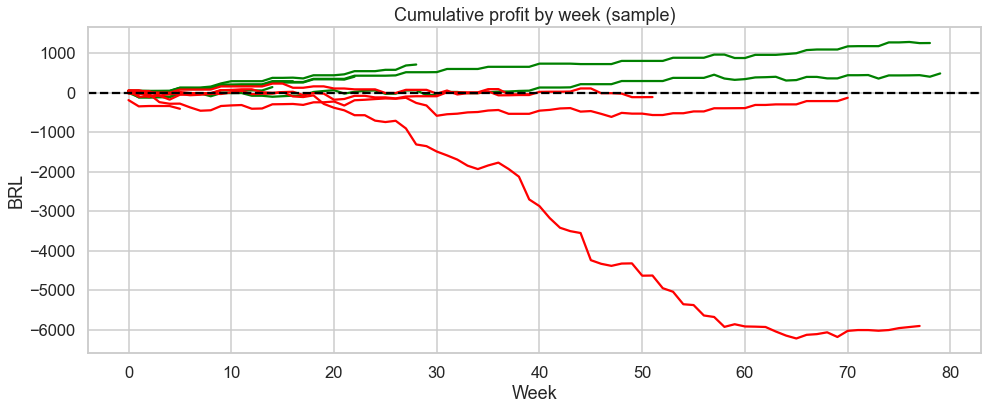

In [22]:
s = 10
r = 6

good_seller_ids_sample = good_seller_ids.sample(s, random_state=r)
bad_seller_ids_sample  = bad_seller_ids.sample(s, random_state=r)
seller_ids_sample = good_seller_ids_sample.append(bad_seller_ids_sample)


fig, ax = plt.subplots(1,1,figsize=(16,6))
for i in seller_ids_sample:
    if sellers.loc[sellers.seller_id == i].seller_type.values[0] == "Good":
        sns.lineplot(x=seller_data[i].index,y="cum_profit",data=seller_data[i],color="green")
    if sellers.loc[sellers.seller_id == i].seller_type.values[0] == "Bad":
        sns.lineplot(x=seller_data[i].index,y="cum_profit",data=seller_data[i],color="red")
ax.axhline(0, ls='--',color="black")
   
ax.set_title("Cumulative profit by week (sample)");
ax.set_ylabel("BRL");
ax.set_xlabel("Week");


*Reb: Bad sellers, Green: Good sellers*

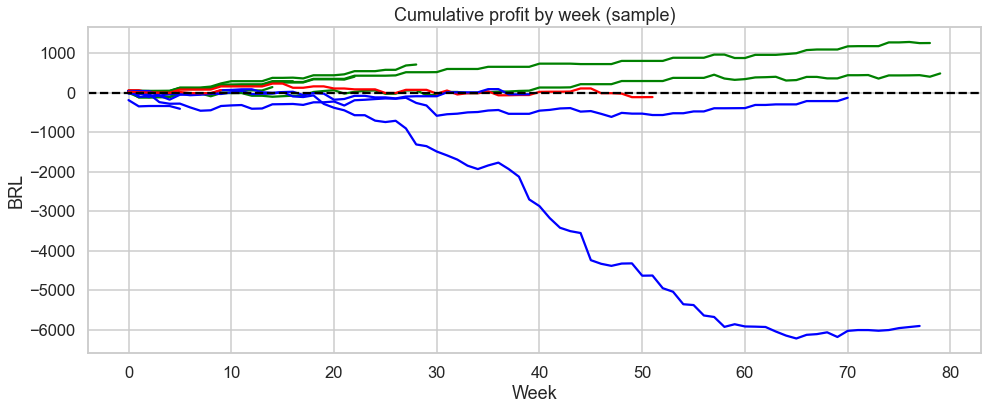

In [23]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
for i in seller_ids_sample:
    if seller_data[i].loc[min(week_threshold,seller_data[i].shape[0]-1),"cum_profit"] > profit_threshold:
        if sellers.loc[sellers.seller_id == i].seller_type.values[0] == "Good":
            sns.lineplot(x=seller_data[i].index,y="cum_profit",data=seller_data[i],color="green")
        if sellers.loc[sellers.seller_id == i].seller_type.values[0] == "Bad":
            sns.lineplot(x=seller_data[i].index,y="cum_profit",data=seller_data[i],color="red")
    else :
        sns.lineplot(x=seller_data[i].index,y="cum_profit",data=seller_data[i],color="blue")
        balance.append(seller_data[i]["cum_profit"].iloc[-1]-seller_data[i].loc[min(week_threshold,seller_data[i].shape[0]-1),"cum_profit"])

ax.axhline(0, ls='--',color="black")   
ax.set_title("Cumulative profit by week (sample)");
ax.set_ylabel("BRL");
ax.set_xlabel("Week");

*Reb: Bad sellers, Green: Good sellers, Blue: sellers to remove*

- Condition: positive cumulative profit after 20 weeks
- Gain: 191 759 BRL (versus 431 727 BRL)